# 用 LangGraph 实现 Translation Agent

In [1]:
! pip install langgraph langsmith langchain-openai

  Obtaining dependency information for langgraph from https://files.pythonhosted.org/packages/5c/b3/45ebe04a87f75aad88abaef65381467cda537e6c3eb014d51012b8cf479b/langgraph-0.2.4-py3-none-any.whl.metadata
  Obtaining dependency information for langgraph-checkpoint<2.0.0,>=1.0.2 from https://files.pythonhosted.org/packages/20/16/b4e6ab4d078e7024c1ae40377a18885d25268388ed239dbd6fb81c466ffe/langgraph_checkpoint-1.0.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 4.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


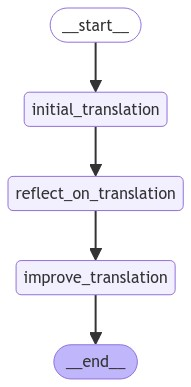

================================ Human Message =================================

静夜思 \n 床前明月光，疑是地上霜。\n 举头望明月，低头思故乡。 
================================== Ai Message ==================================

Quiet Night Thoughts

Before my bed, the bright moonlight,
I suspect it's frost on the ground.
I lift my head to gaze at the bright moon,
Lower it, and think of my hometown.
================================== Ai Message ==================================

1. Title: Consider a more poetic translation of the title, such as "Thoughts on a Tranquil Night," to better capture the contemplative nature of the poem.

2. Line 1: "Before my bed, the bright moonlight" - Rephrase to "Moonlight before my bed" to improve fluency and maintain the concise style of the original.

3. Line 2: "I suspect it's frost on the ground" - Rephrase to "I wonder if it's frost on the ground" to better match the tone of quiet contemplation.

4. Line 3: "I lift my head to gaze at the bright moon" - Simplify to "I lift my 

'\n静夜思\n床前明月光，疑是地上霜。\n举头望明月，低头思故乡。\n'

In [18]:
# langgraph 实现 translation agent
# langgraph 简单示例
from typing import TypedDict, Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

llm = ChatOpenAI(model="gpt-4o")
source_lang = "Chinese"
target_lang = "English"


class State(TypedDict):
    messages: Annotated[list, add_messages]

def initial_translation(state: State):
    source_text = state["messages"][-1].content
    system_prompt = f"You are an expert linguist, specializing in translation from {source_lang} to {target_lang}."
    translation_prompt = f"""This is an {source_lang} to {target_lang} translation, please provide the {target_lang} translation for this text. \
    Do not provide any explanations or text apart from the translation.
    {source_lang}: {source_text}

    {target_lang}:"""

    messages = [
        (
            "system",
            system_prompt,
        ),
        ("human", translation_prompt),
    ]
    return {"messages": [llm.invoke(messages)]}

def reflect_on_translation(state: State):
    country = "America"
    # 获取输入的原文（User 消息）
    source_text = state["messages"][-2].content
    # 获取翻译（Assistant 消息）
    translation_1 = state["messages"][-1].content
    system_message = f"You are an expert linguist specializing in translation from {source_lang} to {target_lang}. \
You will be provided with a source text and its translation and your goal is to improve the translation."
    
    reflection_prompt = f"""Your task is to carefully read a source text and a translation from {source_lang} to {target_lang}, and then give constructive criticism and helpful suggestions to improve the translation. \
    The final style and tone of the translation should match the style of {target_lang} colloquially spoken in {country}.

    The source text and initial translation, delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT> and <TRANSLATION></TRANSLATION>, are as follows:

    <SOURCE_TEXT>
    {source_text}
    </SOURCE_TEXT>

    <TRANSLATION>
    {translation_1}
    </TRANSLATION>

    When writing suggestions, pay attention to whether there are ways to improve the translation's \n\
    (i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),\n\
    (ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules, and ensuring there are no unnecessary repetitions),\n\
    (iii) style (by ensuring the translations reflect the style of the source text and take into account any cultural context),\n\
    (iv) terminology (by ensuring terminology use is consistent and reflects the source text domain; and by only ensuring you use equivalent idioms {target_lang}).\n\

    Write a list of specific, helpful and constructive suggestions for improving the translation.
    Each suggestion should address one specific part of the translation.
    Output only the suggestions and nothing else."""
        
    messages = [
        (
            "system",
            system_message,
        ),
        ("human", reflection_prompt),
    ]
    return {"messages": [llm.invoke(messages)]}


def improve_translation(state: State):
    # 输入原文（User 消息）
    source_text = state["messages"][-3].content
    # 初始翻译结果（Assistant 消息）
    translation_1 = state["messages"][-2].content
    # 反思建议（Assistant 消息）
    reflection = state["messages"][-1].content

    system_message = f"You are an expert linguist, specializing in translation editing from {source_lang} to {target_lang}."

    improve_prompt = f"""Your task is to carefully read, then edit, a translation from {source_lang} to {target_lang}, taking into
    account a list of expert suggestions and constructive criticisms.

    The source text, the initial translation, and the expert linguist suggestions are delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT>, <TRANSLATION></TRANSLATION> and <EXPERT_SUGGESTIONS></EXPERT_SUGGESTIONS> \
    as follows:

    <SOURCE_TEXT>
    {source_text}
    </SOURCE_TEXT>

    <TRANSLATION>
    {translation_1}
    </TRANSLATION>

    <EXPERT_SUGGESTIONS>
    {reflection}
    </EXPERT_SUGGESTIONS>

    Please take into account the expert suggestions when editing the translation. Edit the translation by ensuring:

    (i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),
    (ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules and ensuring there are no unnecessary repetitions), \
    (iii) style (by ensuring the translations reflect the style of the source text)
    (iv) terminology (inappropriate for context, inconsistent use), or
    (v) other errors.

    Output only the new translation and nothing else."""

    messages = [
        (
            "system",
            system_message,
        ),
        ("human", improve_prompt),
    ]
    return {"messages": [llm.invoke(messages)]}

workflow = StateGraph(State)
workflow.add_node("initial_translation", initial_translation)
workflow.add_node("reflect_on_translation", reflect_on_translation)
workflow.add_node("improve_translation", improve_translation)
# 定义 DAG
workflow.set_entry_point("initial_translation")
workflow.add_edge("initial_translation", "reflect_on_translation")
workflow.add_edge("reflect_on_translation", "improve_translation")
workflow.add_edge("improve_translation", END)
#workflow.add_edge("chat", "__end__")
#workflow.set_finish_point("chat")
graph = workflow.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

"""
静夜思\n
床前明月光，疑是地上霜。\n
举头望明月，低头思故乡。\n
"""

user_input = input("输入中翻英内容: ")
events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()


# for event in graph.stream({"messages": ("user", user_input)}):
#     for value in event.values():
#         print("Assistant:", value["messages"][-1].content)